In [1]:
!pip install pytorch-lightning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import Lambda
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import Accuracy, F1Score
import datetime


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class CNNModel(pl.LightningModule):
    def __init__(self, lr=1e-3, input_channels=1, n_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.input_channels = input_channels
        self.n_classes = n_classes

        # Define la red CNN con Batch Normalization
        self.conv1 = nn.Conv2d(self.input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.n_classes)

        # Métrica de Accuracy
        self.train_accuracy = Accuracy(task='multiclass', num_classes=self.n_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=self.n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits_tr = self.forward(x)
        loss_tr = F.cross_entropy(logits_tr, y)
        preds_tr = logits_tr.argmax(dim=1)
        acc_tr = self.train_accuracy(preds_tr, y)
        self.log_dict({
            'train_loss': loss_tr,
            'train_acc': acc_tr
            },
                      prog_bar=True,
                      on_epoch=True, on_step=False)
        return loss_tr

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits_val = self.forward(x)
        loss_val = F.cross_entropy(logits_val, y)
        preds_val = logits_val.argmax(dim=1)
        acc_val = self.val_accuracy(preds_val, y)
        self.log_dict({
            'val_loss': loss_val,
            'val_acc': acc_val
            },
                      prog_bar=True,
                      on_epoch=True, on_step=False)

        return loss_val

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits_te = self.forward(x)
        loss_te = F.cross_entropy(logits_te, y)
        preds_te = logits_te.argmax(dim=1)
        acc_te = self.val_accuracy(preds_te, y)
        self.log_dict({
            'test_loss': loss_te,
            'test_acc': acc_te
            },
                      prog_bar=True,
                      on_epoch=True, on_step=False)

        return loss_te


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        # Transformaciones
        self.train_transform = transforms.Compose([
            transforms.Resize((150, 150)),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.val_test_transform = transforms.Compose([
            transforms.Resize((150, 150)),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        datasets.MNIST(root="data", train=True, download=True)
        datasets.MNIST(root="data", train=False, download=True)

    def setup(self, stage=None):
        if stage in (None, "fit"):
            mnist_full = datasets.MNIST(root="data", train=True, transform=self.val_test_transform)
            self.train_dataset, self.val_dataset = random_split(
                mnist_full,
                [55000, 5000],
                generator=torch.Generator().manual_seed(42)
            )
            self.train_dataset.dataset.transform = self.train_transform

        if stage == "test" or stage is None:
            self.test_dataset = datasets.MNIST(root="data", train=False, transform=self.val_test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


In [4]:
from pytorch_lightning import Trainer

# Configuración del logger
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema6/results/"
logger = CSVLogger(save_dir=path, name="metrics")

# Instancia del modelo y datamodule
model = CNNModel(lr=1e-3)
data_module = MNISTDataModule(batch_size=256)



early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    patience=3, # número de epochs sin mejora antes de parar
    min_delta=0.001, # diferencia mínima para considerar que hay mejora
    verbose=False, # si queremos que muestre mensajes del estado del early stopping
)
model_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=path, # directorio donde se guardan los modelos
    filename=f'best_model_{datetime.datetime.now()}' # nombre del archivo
)
callbacks = [early_stopping_callback, model_checkpoint_callback]






# Configuración del trainer
trainer = Trainer(
    max_epochs=40,
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=1,
    callbacks=callbacks
)

# Entrenamiento
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema6/results exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name           | Type               | Params | Mode 
---------------------------------------------------------------
0  | conv1          | Conv2d             | 320    | train
1  | bn1            | BatchNorm2d        | 64     | train
2  | conv2          | Conv2d             | 18.5 K | train
3  | bn2            | BatchNorm2d        | 128    | train
4  | conv3          | Conv2d             | 73.9

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [6]:
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema6/results/"
model_file = "best_model_2024-12-04 13:38:35.021830.ckpt"
checkpoint_path = path + model_file
loaded_model = CNNModel.load_from_checkpoint(checkpoint_path)

In [13]:
path = "/content/drive/My Drive/Trabajo/Docencia/curso_24_25/titulo_propio/dl/tema6/results/"
logger = CSVLogger(save_dir=path, name="metrics_test")

data_module = MNISTDataModule(batch_size=256)

trainer = Trainer(accelerator="gpu",logger=logger,)

# Testear el modelo cargado
test_results = trainer.test(loaded_model, datamodule=data_module)

# Mostrar resultados
print("Resultados del test:", test_results)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9855999946594238     │
│         test_loss         │    0.0453721359372139     │
└───────────────────────────┴───────────────────────────┘

Resultados del test: [{'test_loss': 0.0453721359372139, 'test_acc': 0.9855999946594238}]


In [14]:
import matplotlib.pyplot as plt


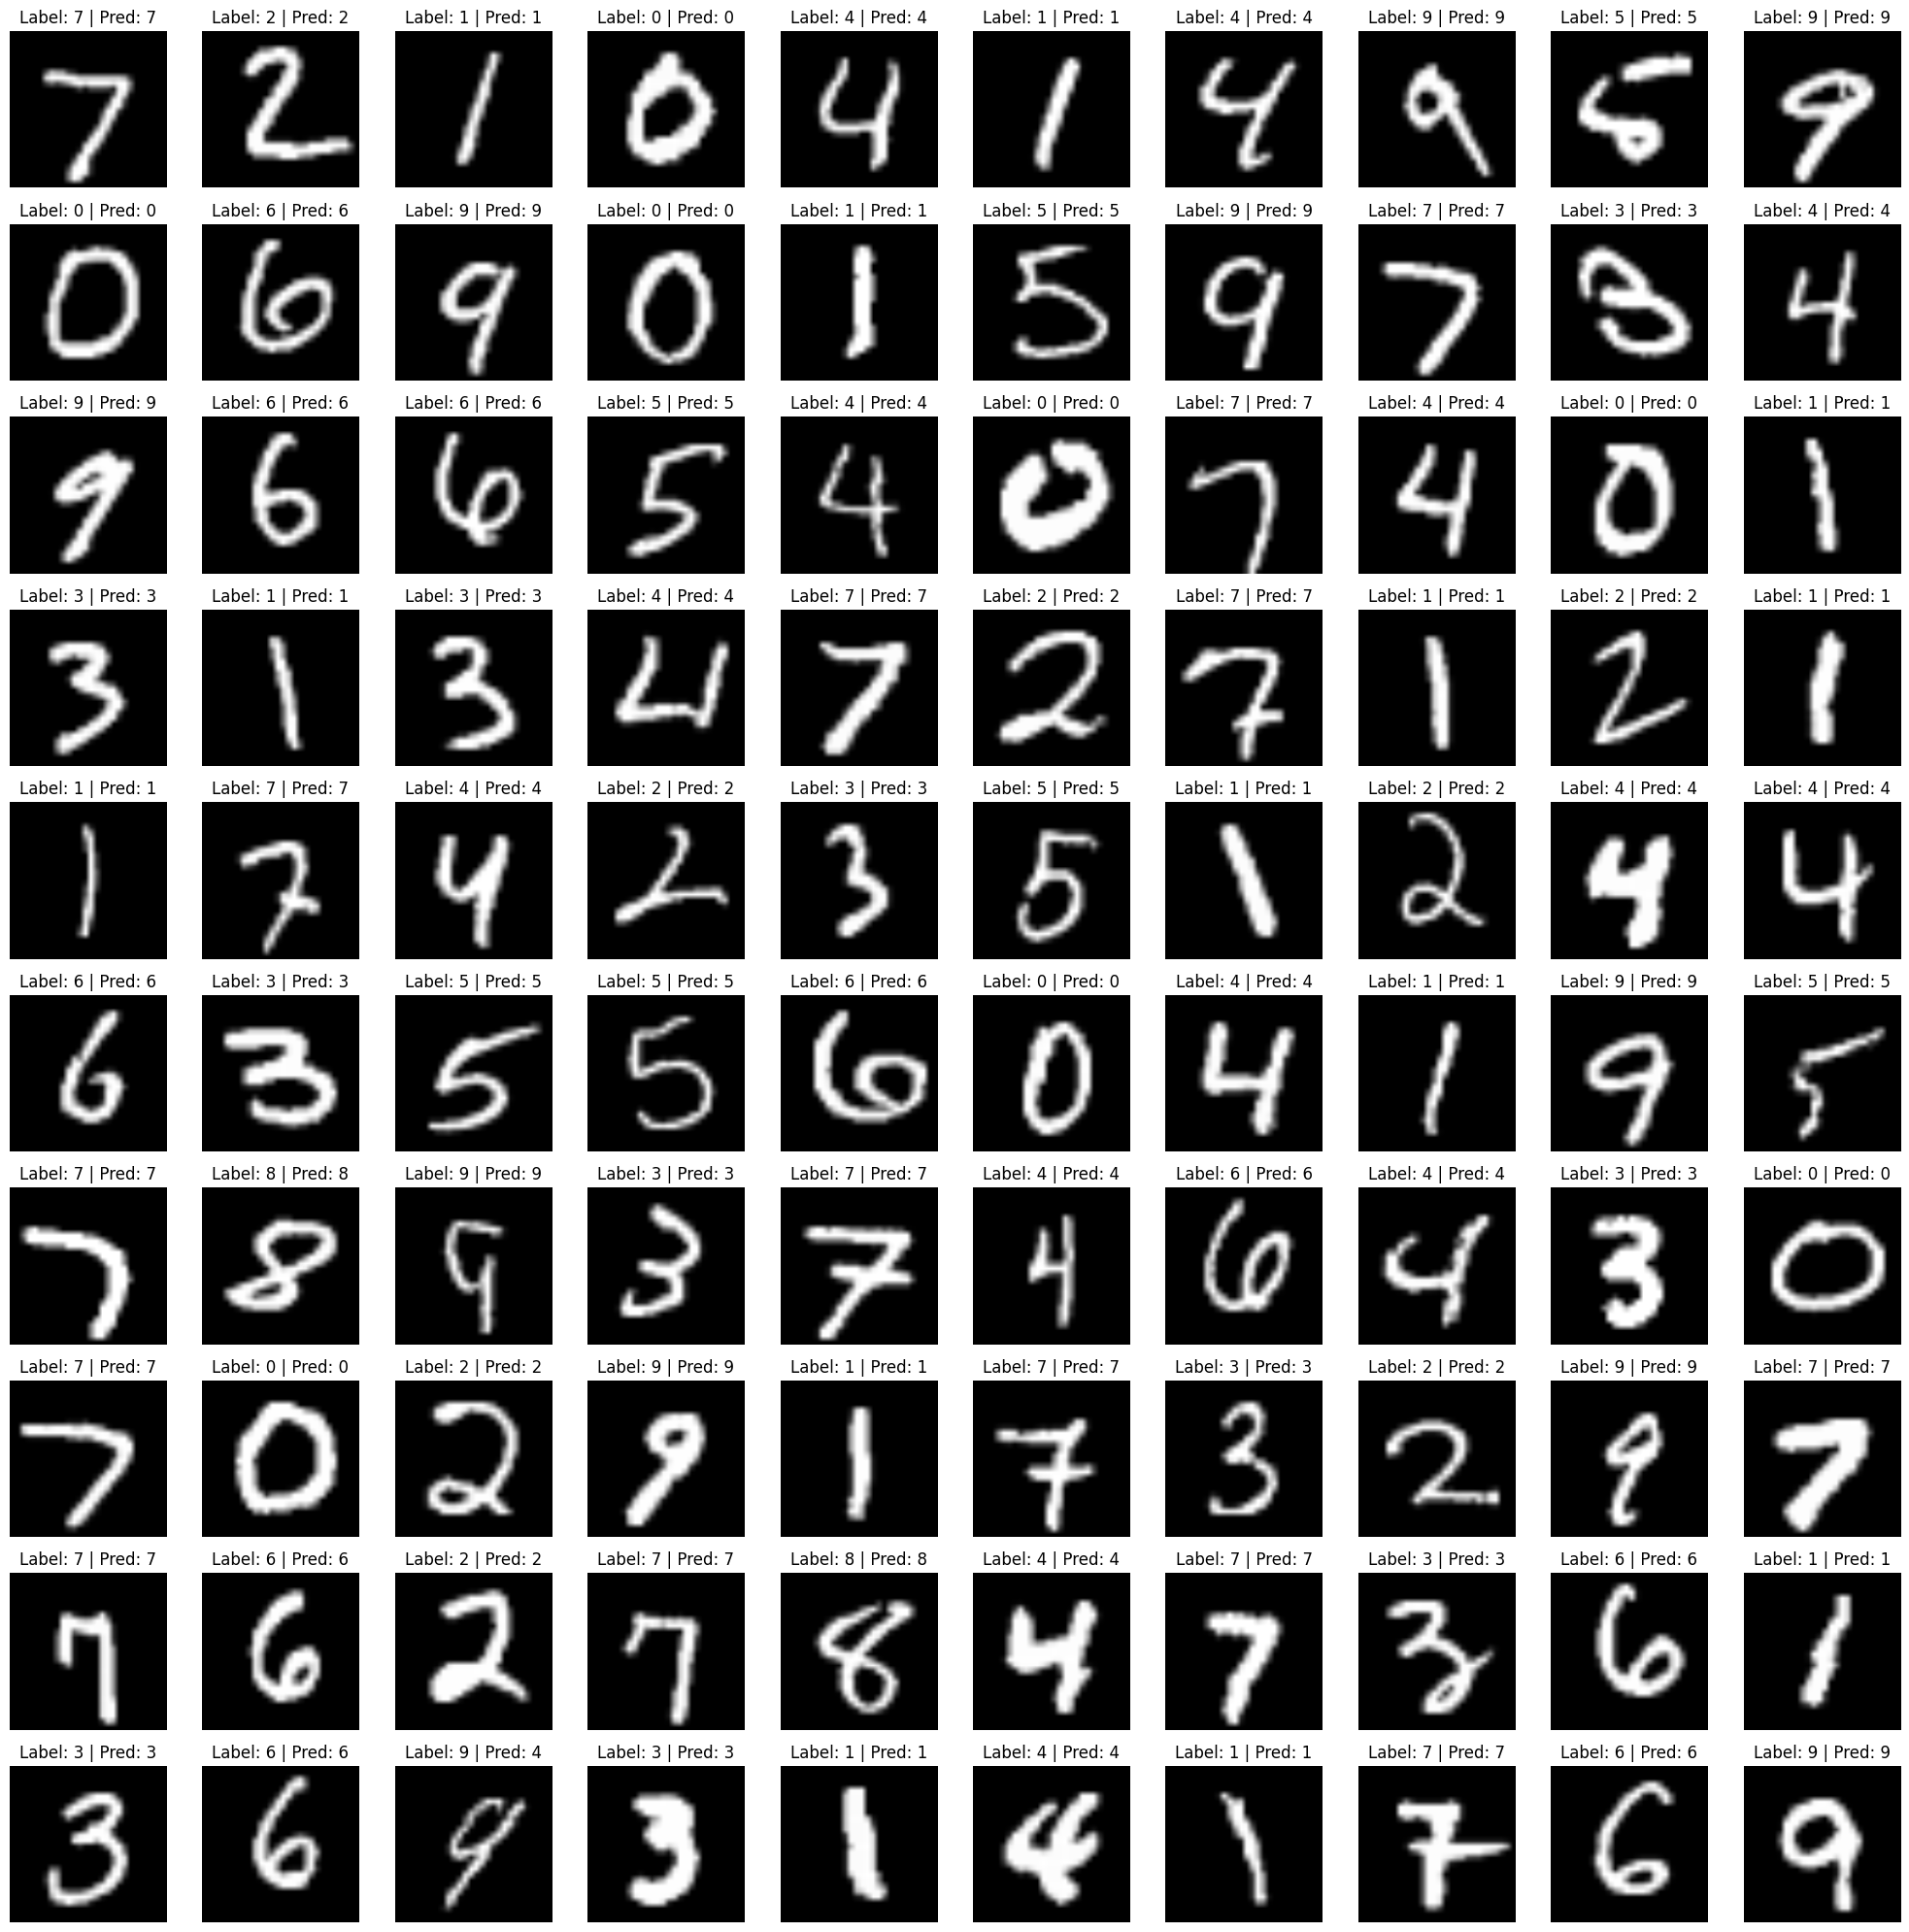

In [15]:
# Función para realizar inferencia y mostrar las imágenes
def plot_predictions(model, datamodule, num_samples=100):
    # Configuración para mostrar 5x5
    rows, cols = 10, 10
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
    axs = axs.flatten()

    # Obtener un lote del conjunto de prueba
    dataloader = datamodule.test_dataloader()
    batch = next(iter(dataloader))
    images, labels = batch
    images = images[:num_samples]
    labels = labels[:num_samples]

    # Poner el modelo en modo de evaluación
    model.eval()
    model.to("cuda")  # Asegurarte de mover el modelo a GPU si es necesario

    # Realizar la inferencia
    with torch.no_grad():
        predictions = model(images.to("cuda")).argmax(dim=1).cpu()

    # Mostrar las imágenes con etiquetas y predicciones
    for i in range(num_samples):
        ax = axs[i]
        img = images[i].squeeze().cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Label: {labels[i].item()} | Pred: {predictions[i].item()}")
        ax.axis("off")

    # Ajustar la cuadrícula
    for ax in axs[num_samples:]:
        ax.remove()

    plt.tight_layout()
    plt.show()

# Usar la función con el modelo y datamodule cargados
plot_predictions(loaded_model, data_module)

In [16]:
from torchmetrics.classification import ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch



In [17]:
class ConfusionMatrixCallback(pl.Callback):
    def __init__(self, num_classes, normalize=None):
        super().__init__()
        self.num_classes = num_classes
        self.normalize = normalize  # 'true', 'pred', or None for normalization
        self.confmat = ConfusionMatrix(task="multiclass", num_classes=10)

    def on_test_epoch_start(self, trainer, pl_module):
        # Reinicia la métrica antes de cada testeo
        self.confmat.reset()

    def on_test_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        # Actualiza la matriz de confusión con predicciones y etiquetas
        x, y = batch
        logits = pl_module(x.to(pl_module.device))
        preds = logits.argmax(dim=1)
        self.confmat.update(preds.cpu(), y.cpu())

    def on_test_epoch_end(self, trainer, pl_module):
        # Obtén la matriz de confusión
        conf_matrix = self.confmat.compute().cpu().numpy()

        # Visualiza la matriz de confusión
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(self.num_classes))
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, cmap='viridis', colorbar=True)
        plt.title("Confusion Matrix")
        plt.show()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

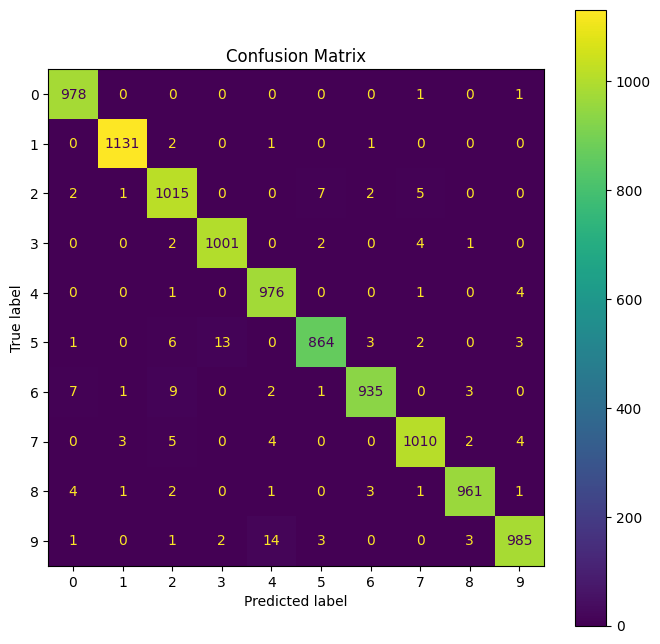

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9855999946594238     │
│         test_loss         │    0.0453721359372139     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0453721359372139, 'test_acc': 0.9855999946594238}]

In [18]:
# Añadir el callback al entrenador
conf_matrix_callback = ConfusionMatrixCallback(num_classes=model.n_classes)

trainer = Trainer(
    accelerator="gpu",
    logger=logger,
    callbacks=[conf_matrix_callback]
)

# Testear el modelo y mostrar la matriz de confusión
trainer.test(loaded_model, datamodule=data_module)
